## What to do?
* Familiarize yourself with modeling. If mentioned models in this exercise are not enough, you can surely find more methods in scikit-learn. You can use another descriptors, e.g. fingerprints.
* Find some well predictig solution set of model and descriptors on your data

# Modelování
Budu předpovídat aktivitu na cox ligandech.

In [1]:
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn import ensemble
from sklearn import model_selection as ms
from sklearn.metrics import mean_squared_error

# rdkit mols are displayed as images
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit.Chem.SaltRemover import SaltRemover

# descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

# plots
from matplotlib import pyplot as plt
import seaborn

# other packages
import pandas as pd
import numpy as np
import csv
import re

from sklearn.preprocessing import StandardScaler
import emoji
from scipy.stats import pearsonr
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

## Standardizace

Provedla jsem standardizaci sloučenin podle původního zadání.

In [88]:
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol, replaced

In [89]:
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]") # to remove compounds with unwanted atom types
_carbonPatt = Chem.MolFromSmarts("[#6]") # to remove compounds without carbon - inorganic
def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol, neutralized = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol) # add catch block?
                return mol
    else:
        return None

In [90]:
# some pChEMBL values in our file are not valid floats
float_pattern = re.compile("[0-9]+(\.[0-9]*)?")

# function for Lipinski's descriptors
lip_func = [("HBA", Lipinski.NumHAcceptors), ("HBD", Lipinski.NumHDonors), ("MW", Descriptors.ExactMolWt),
            ("LogP", Descriptors.MolLogP), ("TPSA", rdMolDescriptors.CalcTPSA), ("RB", Lipinski.NumRotatableBonds)]

**Načtení mé ligandové sady pro cyklooxygenázu 1 cox1**

In [91]:
raw_df = pd.read_csv('data/cyclooxygenase_1.csv', sep=';') 

# odstraneni dat, ktere nemaji IC50 nebo maji jinou jednotku nez nM,
# tim se odstrani data, ktere nemaji Smiles
df = raw_df[(raw_df['Standard Units'] == 'nM')]

df.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL270043,NaN,0,306.34,0,1.80,22,COc1ccc(/C=N/c2ccc(S(N)(=O)=O)cc2)cc1O,IC50,'=',...,Cyclooxygenase-1,Homo sapiens,SINGLE PROTEIN,CHEMBL1141614,1,Scientific Literature,Bioorg. Med. Chem.,2008.0,None,NaN
1,CHEMBL270264,NaN,0,306.34,0,1.80,19,COc1cc(/C=N/c2ccc(S(N)(=O)=O)cc2)ccc1O,IC50,'=',...,Cyclooxygenase-1,Homo sapiens,SINGLE PROTEIN,CHEMBL1141614,1,Scientific Literature,Bioorg. Med. Chem.,2008.0,None,NaN
2,CHEMBL260386,NaN,0,281.24,0,2.93,22,Nc1ccc(C(=O)Nc2ccc(C(F)(F)F)cc2)nc1,IC50,'>',...,Cyclooxygenase-1,Homo sapiens,SINGLE PROTEIN,CHEMBL1144769,1,Scientific Literature,J. Med. Chem.,2008.0,None,NaN
3,CHEMBL259972,MOFEZOLAC,0,339.35,0,3.65,"4, mofezolac",COc1ccc(-c2noc(CC(=O)O)c2-c2ccc(OC)cc2)cc1,IC50,'=',...,Cyclooxygenase-1,Homo sapiens,SINGLE PROTEIN,CHEMBL1144769,1,Scientific Literature,J. Med. Chem.,2008.0,None,NaN
4,CHEMBL122,ROFECOXIB,4,314.36,0,2.56,Rofecoxib,CS(=O)(=O)c1ccc(C2=C(c3ccccc3)C(=O)OC2)cc1,IC50,'=',...,Cyclooxygenase-1,Homo sapiens,SINGLE PROTEIN,CHEMBL1145760,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2003.0,None,NaN


In [92]:
# vsechny data v df maji standard typu IC50 a vsechny maji jednotky nM 
print(df['Standard Type'].unique())
print(df['Standard Units'].unique())
print('nan\t',sum(pd.isnull(df['Standard Units'])))

['IC50']
['nM']
nan	 0


In [94]:
df_cox=pd.DataFrame()

# vytvoreni vsech potrebnych sloupcu
df_cox['smiles'] = df['Smiles']
df_cox['rdmol'] = df['Smiles'].apply(lambda x: Chem.MolFromSmiles(x))
df_cox['source'] = 'cox1'
df_cox['pChEMBL_value'] = df['pChEMBL Value'].apply(lambda x: float(x) if float_pattern.match(str(x)) else 0)
df_cox["standard_value"] = df['Standard Value'].apply(lambda x: float(x) if float_pattern.match(str(x)) else np.NaN)
df_cox['std_rdmol'] = df_cox['rdmol'].apply(lambda x: standardize(x))
df_cox["std_smiles"] = df_cox['std_rdmol'].apply(lambda x: Chem.MolToSmiles(x) if x else None)
df_cox['fps'] = df_cox['std_rdmol'].apply(lambda x: Chem.GetMorganFingerprintAsBitVect(x,2,nBits=1024) if x else None)

for f in lip_func:
        df_cox[f[0]] = df_cox['std_rdmol'].apply(lambda x: f[1](x) if x else None)

In [95]:
# 7 sloucenin nema std_rdmol
print(df_cox.isnull().sum())

smiles            0
rdmol             0
source            0
pChEMBL_value     0
standard_value    0
std_rdmol         7
std_smiles        7
fps               7
HBA               7
HBD               7
MW                7
LogP              7
TPSA              7
RB                7
dtype: int64


In [96]:
# vzhozeni sloucenin, ktere nemaji std_rdmol
df_cox = df_cox.dropna()
print(df_cox.isnull().sum())

smiles            0
rdmol             0
source            0
pChEMBL_value     0
standard_value    0
std_rdmol         0
std_smiles        0
fps               0
HBA               0
HBD               0
MW                0
LogP              0
TPSA              0
RB                0
dtype: int64


In [97]:
mx_cox = df_cox["standard_value"].max()+1
df_cox["standard_value"] = df_cox["standard_value"].fillna(mx_cox+1)

In [98]:
df_cox = df_cox.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df_cox["std_rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )

In [17]:
# musela jsem odstranit 671 souboru, protze nemely deskriptory MQN
df_cox = df_cox.dropna()
# vypsat jen pro kontrolu 
print(df_cox.isnull().sum())

smiles            0
rdmol             0
source            0
pChEMBL_value     0
standard_value    0
std_rdmol         0
std_smiles        0
fps               0
HBA               0
HBD               0
MW                0
LogP              0
TPSA              0
RB                0
MQN_1             0
MQN_2             0
MQN_3             0
MQN_4             0
MQN_5             0
MQN_6             0
MQN_7             0
MQN_8             0
MQN_9             0
MQN_10            0
MQN_11            0
MQN_12            0
MQN_13            0
MQN_14            0
MQN_15            0
MQN_16            0
MQN_17            0
MQN_18            0
MQN_19            0
MQN_20            0
MQN_21            0
MQN_22            0
MQN_23            0
MQN_24            0
MQN_25            0
MQN_26            0
MQN_27            0
MQN_28            0
MQN_29            0
MQN_30            0
MQN_31            0
MQN_32            0
MQN_33            0
MQN_34            0
MQN_35            0
MQN_36            0


- dělám predikce jen pro moji sadu ligandů

### Použití MQN deskriptorů

## Hodnota standard value (v mém případě IC50)

- nejdříve jsem tedy použila jako vysvětlovanou proměnnou standard value, ale ta vycházela obecně hrozně
- ani jeden model nebyl schopen ji správně predikovat

- použila jsem tady jen **SVR** a **RandomForest**

### SVR
- support vector machine / pouziti jadrove funkce

In [18]:
svr = svm.SVR()
svr.fit(df_cox[df_cox["standard_value"]<mx_cox][(f"MQN_{x}" for x in range(1, 43))], df_cox[df_cox["standard_value"]<mx_cox]["standard_value"])

SVR()

In [19]:
res = pd.DataFrame(svr.predict(df_cox[(f"MQN_{x}" for x in range(1, 43))])).join(df_cox[["standard_value"]])
res.columns = ["prediction", "standard_value"]
(res["prediction"]-res["standard_value"]).abs().mean()

119141.30528143355

### Použitá funkce pro získání výsledků

In [20]:
def get_results(model, data, descriptors, predicted_value):
    res = pd.DataFrame(model.predict(data[descriptors])).join(data[[predicted_value]])
    res.columns = ["prediction", predicted_value]
    print(f"""Average error whole set: {(res["prediction"]-res[predicted_value]).abs().mean()}""")
#     print('MSE = ', mean_squared_error(res[predicted_value], res["prediction"]))
    return res

In [21]:
res = get_results(svr, df_cox, (f"MQN_{x}" for x in range(1, 43)), "standard_value")

Average error whole set: 119141.30528143355


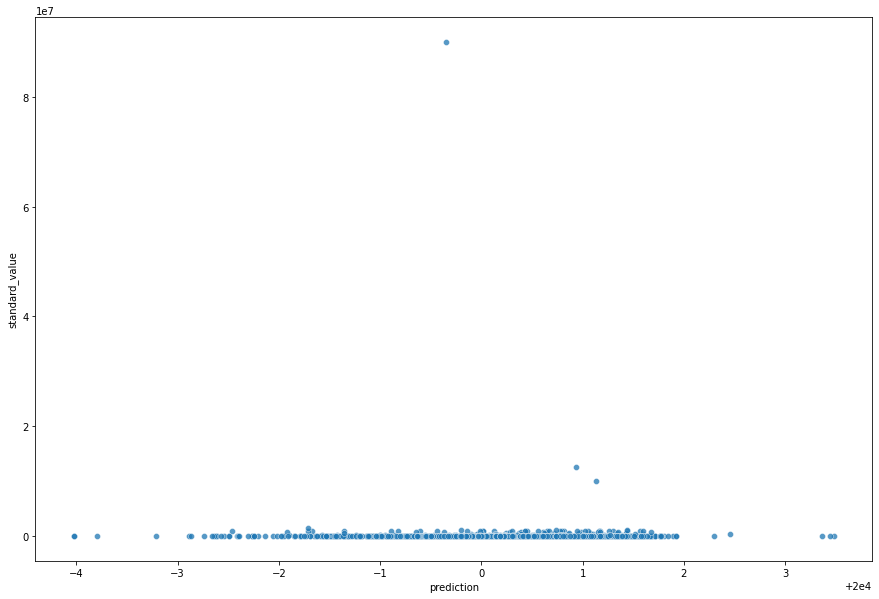

In [22]:
fig, ax = plt.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="prediction",
                      y="standard_value",
                      data=res,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

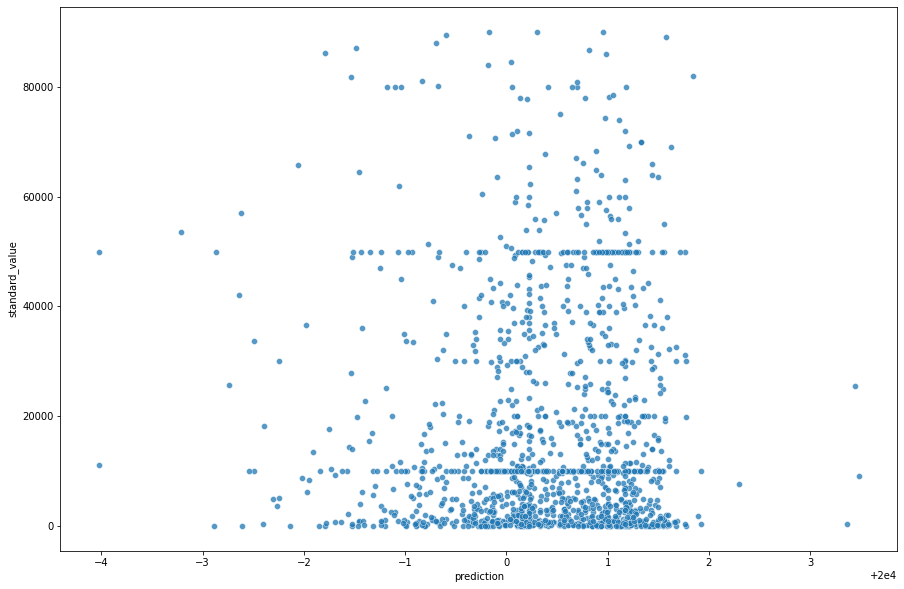

In [23]:
fig, ax = plt.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="prediction",
                      y="standard_value",
                      data=res[res["standard_value"]<mx_cox/1000],
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

### Random forest

In [24]:
rf = ensemble.RandomForestRegressor()
rf.fit(df_cox[df_cox["standard_value"]<mx_cox][(f"MQN_{x}" for x in range(1, 43))], df_cox[df_cox["standard_value"]<mx_cox]["standard_value"])

RandomForestRegressor()

In [25]:
res_rf = get_results(rf, df_cox, (f"MQN_{x}" for x in range(1, 43)), 'standard_value')

Average error whole set: 193585.7148573092


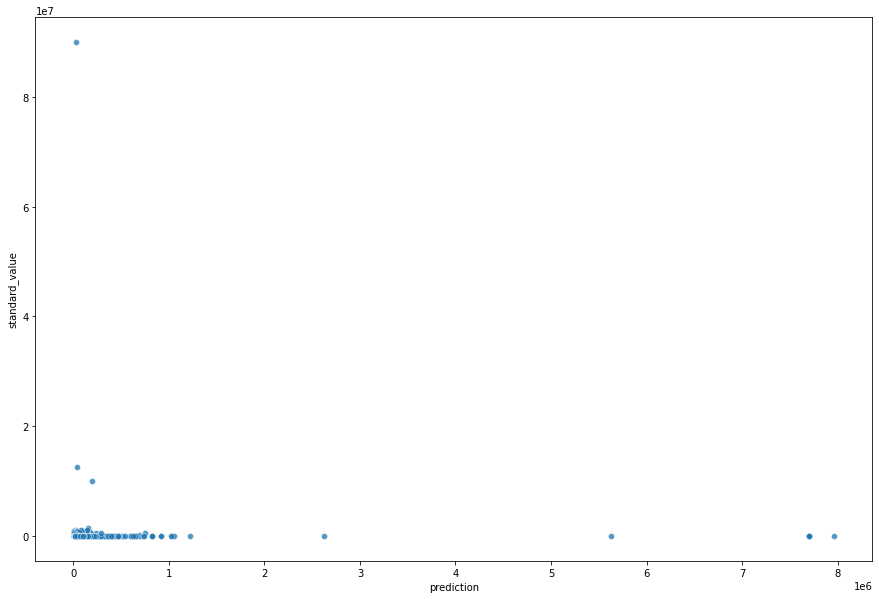

In [26]:
fig, ax = plt.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="prediction",
                      y="standard_value",
                      data=res_rf,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

/home/simik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


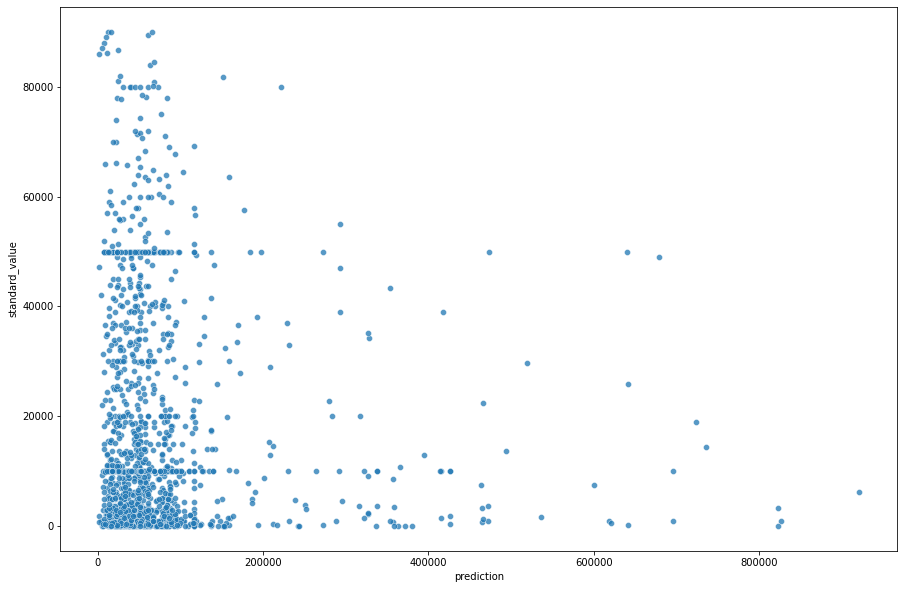

In [27]:
fig, ax = plt.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="prediction",
                      y="standard_value",
                      data=res_rf[res_rf["standard_value"]<mx_cox/1000][res_rf["prediction"]<1e6],
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

Je vidět, že rozsah hodnot je docela široký. Možná log hodnoty budou lepší. Zkusme hodnotu pChEMBL.

## Hodnota pChEMBL
- pro hodnotu pChEMBL to dopadlo také špatně
- modely nebyly schopně predikovat hodnotu pChEMBL
- použila jsem metody z původního zadání **SVR**, **SVR s PCA**,**SVR s kernelem polynomiálním**

### SVR

In [28]:
svr_p = svm.SVR()
svr_p.fit(df_cox[df_cox["pChEMBL_value"]>0][(f"MQN_{x}" for x in range(1, 43))], df_cox[df_cox["pChEMBL_value"]>0]["pChEMBL_value"])

SVR()

In [29]:
res_svr_p = get_results(svr_p, df_cox, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL_value")

Average error whole set: 2.614616767918367


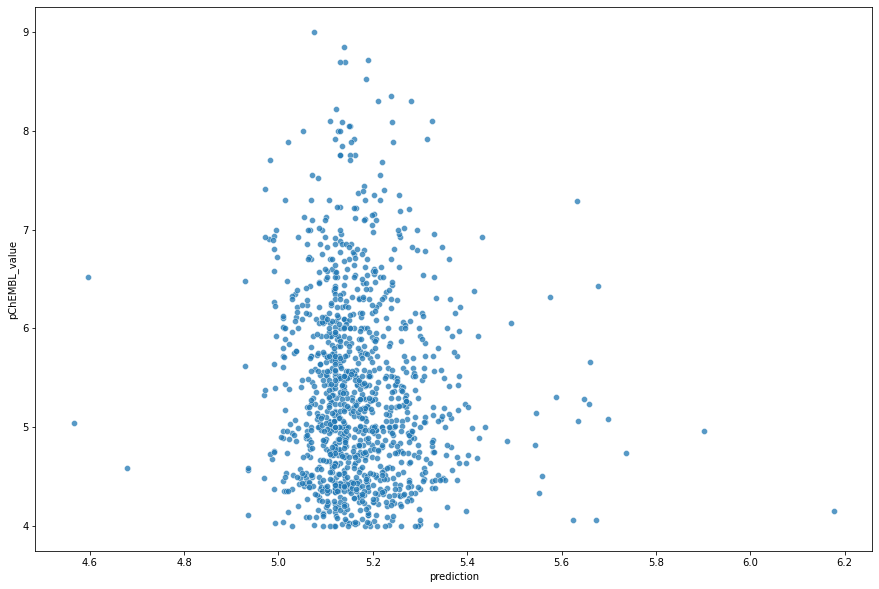

In [30]:
fig, ax = plt.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="prediction",
                      y="pChEMBL_value",
                      data=res_svr_p[res_svr_p["pChEMBL_value"]>0],
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

### SVR with PCA

In [31]:
norm = preprocessing.normalize(df_cox[(f"MQN_{x}" for x in range(1, 43))])
pca = decomposition.PCA(n_components=42)
pca.fit(norm)
df_temp = df_cox.join(pd.DataFrame(pca.transform(norm), columns=[f"nPCA_{x}" for x in range(1, 43)]))

In [32]:
# zase nektere deskriptory MQN nebyly po PCA
df_temp = df_temp.dropna()
print(df_temp.isnull().sum())

smiles            0
rdmol             0
source            0
pChEMBL_value     0
standard_value    0
                 ..
nPCA_38           0
nPCA_39           0
nPCA_40           0
nPCA_41           0
nPCA_42           0
Length: 98, dtype: int64


In [33]:
svr_np = svm.SVR()
svr_np.fit(df_temp[df_temp["standard_value"]<mx_cox][(f"nPCA_{x}" for x in range(1, 43))], df_temp[df_temp["standard_value"]<mx_cox]["pChEMBL_value"])

SVR()

In [34]:
res_svr_np = res = get_results(svr_np, df_temp, (f"nPCA_{x}" for x in range(1, 43)), "pChEMBL_value")

Average error whole set: 2.4911732924488588


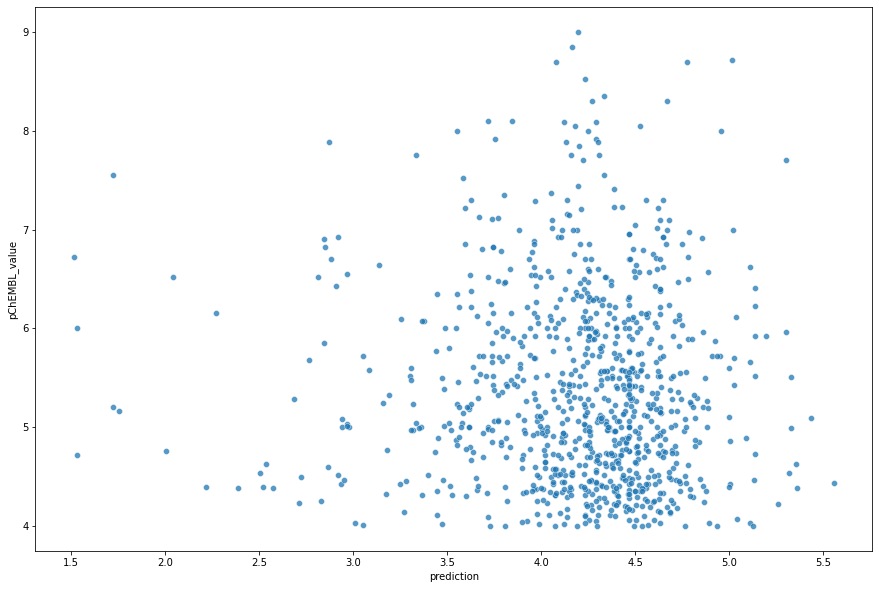

In [35]:
fig, ax = plt.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="prediction",
                      y="pChEMBL_value",
                      data=res_svr_np[res_svr_np["pChEMBL_value"]>0],
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

### SVR with other kernel?

In [36]:
svr_poly = svm.SVR(kernel='poly')
svr_poly.fit(df_temp[df_temp["standard_value"]<mx_cox][(f"nPCA_{x}" for x in range(1, 43))], df_temp[df_temp["standard_value"]<mx_cox]["pChEMBL_value"])

SVR(kernel='poly')

In [37]:
res_poly = get_results(svr_poly, df_temp, (f"nPCA_{x}" for x in range(1, 43)), "pChEMBL_value")

Average error whole set: 2.5448053490429476


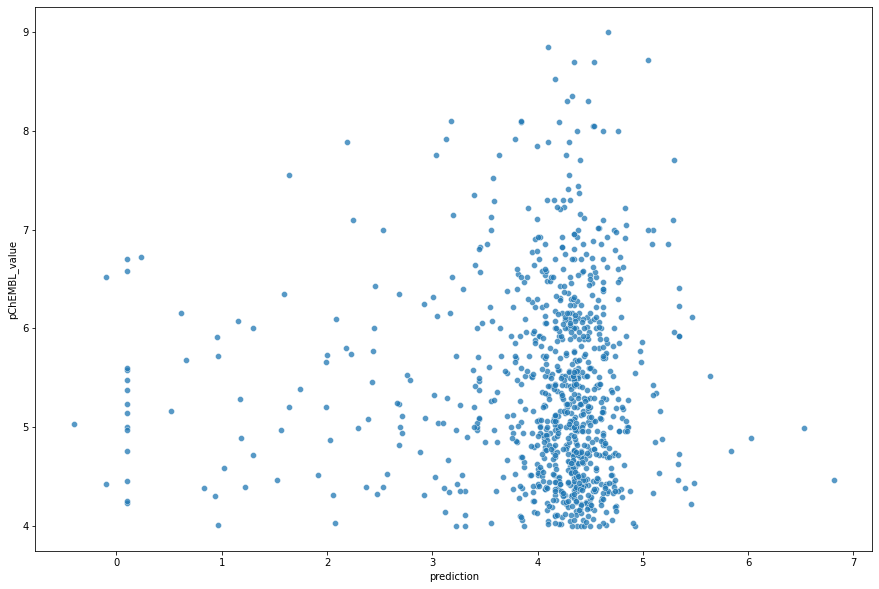

In [38]:
fig, ax = plt.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="prediction",
                      y="pChEMBL_value",
                      data=res_poly[res_poly["pChEMBL_value"]>0],
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## Testovací sada
- nechala jsem v původním rozdělení
- použila jsem **Randomforest**, ale nepredikoval dobře pro testovací sadu

In [39]:
trainset, testset = ms.train_test_split(df_temp[df_temp["pChEMBL_value"]>0])

In [40]:
trainset.reset_index(inplace=True)
testset.reset_index(inplace=True)

In [41]:
# rozdeleni cirka 75:25
len(trainset), len(testset)

(878, 293)

In [42]:
finaly_good_model = ensemble.RandomForestRegressor()
finaly_good_model.fit(trainset[(f"MQN_{x}" for x in range(1, 43))], trainset["pChEMBL_value"])

RandomForestRegressor()

In [43]:
train_results = get_results(finaly_good_model, trainset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL_value")

Average error whole set: 0.3938997583443244


In [44]:
test_results = get_results(finaly_good_model, testset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL_value")

Average error whole set: 0.8095575637025216


In [45]:
print("R^2: %0.2f" % finaly_good_model.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL_value"]))
print("R: %0.2f" % np.sqrt(finaly_good_model.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL_value"])))
print("MSE: %0.2f" %  mean_squared_error(test_results["prediction"], test_results["pChEMBL_value"]))

R^2: -0.15
R: nan
MSE: 1.04


/home/simik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


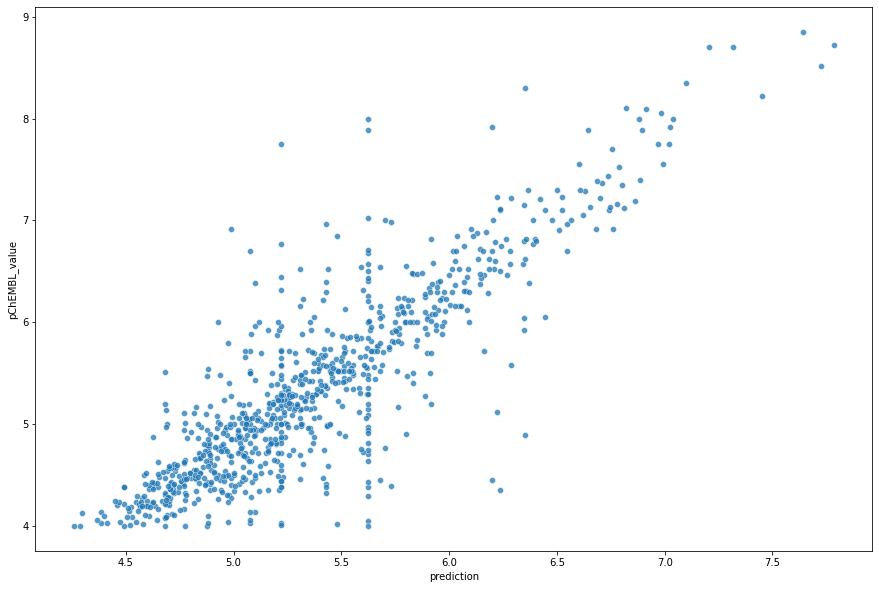

In [46]:
fig, ax = plt.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="prediction",
                      y="pChEMBL_value",
                      data=train_results,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

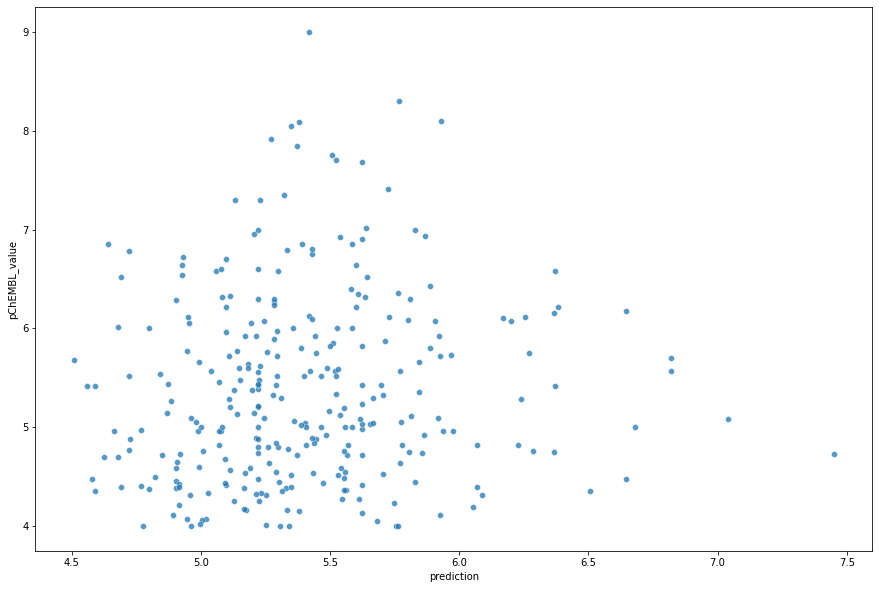

In [47]:
fig, ax = plt.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="prediction",
                      y="pChEMBL_value",
                      data=test_results,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

Závěr je takový, že modely nepredikují dobře, když je natrénujeme na MQN deskriptorech

### Použití fingerprintů
- oproti modelům natrénovaných na MQN deskriptorech dopadly při predikci lépe, ale není to nic moc skvělého
- vyzkoušela jsem modely **RandomForest**, **SVR**, **XGBoost**
- zkoušela jsem také tunit hyperparametry

In [50]:
df_temp=df_cox

trainset, testset = ms.train_test_split(df_cox[df_temp["pChEMBL_value"]>0])
trainset.reset_index(inplace=True)
testset.reset_index(inplace=True)

len(trainset), len(testset)

(1107, 369)

In [51]:
# bylo potreba si prevest fingerprinty, aby mi to modely vzaly 
st = StandardScaler()
X_train = np.array(list(trainset['fps']))
X_train= st.fit_transform(X_train)

X_test = np.array(list(testset['fps']))
X_test= st.fit_transform(X_test)
# trainset['fps'] = [x for x in X]

trochu pozmenime funkci na ziskani vysledku

In [52]:
def get_results_fps(model, data, descriptors, predicted_value):
    res = pd.DataFrame(model.predict(descriptors)).join(data[[predicted_value]])
    res.columns = ["prediction", predicted_value]
    print(f"""Average error whole set: {(res["prediction"]-res[predicted_value]).abs().mean()}""")
    return res

### Random forest

In [194]:
finaly_good_model = ensemble.RandomForestRegressor()
finaly_good_model.fit(X_train, trainset["pChEMBL_value"])

RandomForestRegressor()

In [195]:
train_results = get_results_fps(finaly_good_model, trainset, X_train, "pChEMBL_value")

Average error whole set: 0.25301552793021326


In [183]:
test_results = get_results_fps(finaly_good_model, testset, X_test, "pChEMBL_value")

Average error whole set: 0.49763277094685054


In [184]:
from scipy.stats import pearsonr

In [185]:
print("R^2: %0.2f" % finaly_good_model.score(X_test, testset["pChEMBL_value"]))
print("R: %0.2f" % np.sqrt(finaly_good_model.score(X_test, testset["pChEMBL_value"])))
print("MSE: %0.2f" %  mean_squared_error(test_results["prediction"], test_results["pChEMBL_value"]))
corr, _ = pearsonr(test_results["prediction"], test_results["pChEMBL_value"])
print('Pearsons correlation: %.3f' % corr)

R^2: 0.51
R: 0.71
MSE: 0.50
Pearsons correlation: 0.715


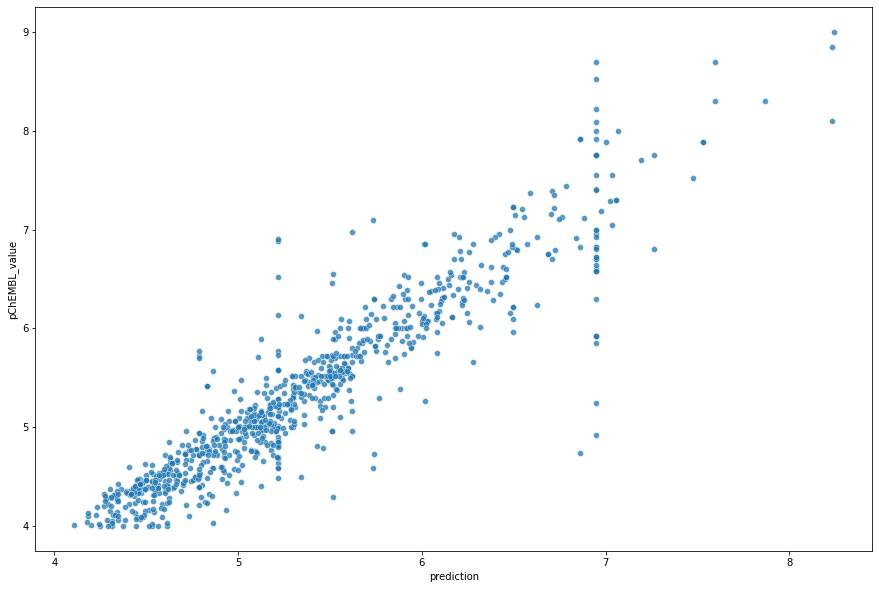

In [67]:
fig, ax = plt.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="prediction",
                      y="pChEMBL_value",
                      data=train_results,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

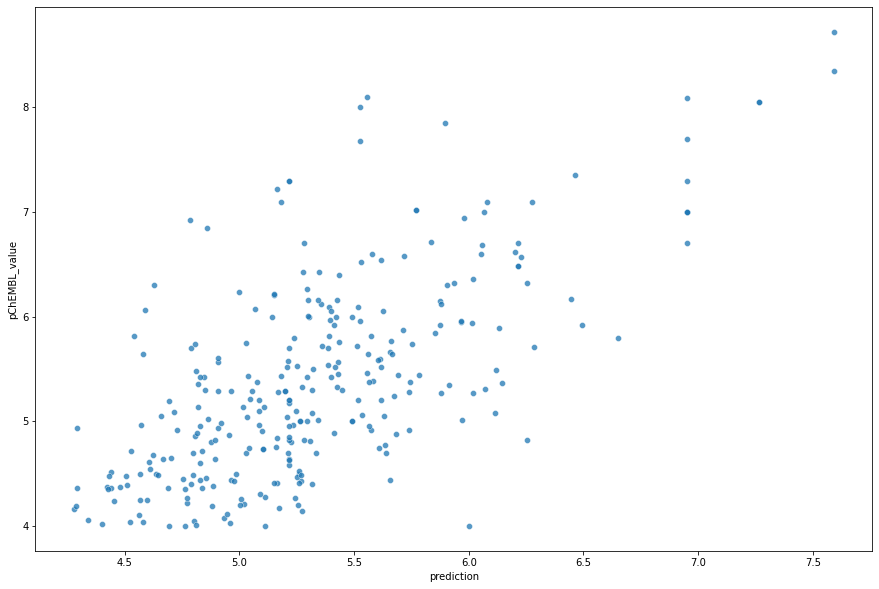

In [68]:
fig, ax = plt.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="prediction",
                      y="pChEMBL_value",
                      data=test_results,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

Tohle vypadá o kapánek lépe než u předchozích deskriptorů

### Laděni hyperparametrů
- tady bylo třeba získat i validační množinu

In [59]:
def get_results_fps_val(model, data, descriptors, predicted_value):
    res = pd.DataFrame(model.predict(descriptors)).join(data[[predicted_value]])
    res.columns = ["prediction", predicted_value]
    return res

In [200]:
trainset, testset = ms.train_test_split(df_temp[df_temp["pChEMBL_value"]>0])
trainset, validationset = ms.train_test_split(trainset) # 0.25 x 0.8 = 0.2

In [201]:
# kontrola, jestli nejsou nekde nulove hodnoty
print(validationset.isnull().sum())

smiles            0
rdmol             0
source            0
pChEMBL_value     0
standard_value    0
std_rdmol         0
std_smiles        0
fps               0
HBA               0
HBD               0
MW                0
LogP              0
TPSA              0
RB                0
dtype: int64


In [202]:
trainset.reset_index(inplace=True)
testset.reset_index(inplace=True)
validationset.reset_index(inplace=True)

len(trainset),len(validationset), len(testset)

(1066, 356, 475)

In [204]:
st = StandardScaler()
X_train = np.array(list(trainset['fps']))
X_train= st.fit_transform(X_train)

X_val = np.array(list(validationset['fps']))
X_val= st.fit_transform(X_val)
X_val

array([[-0.05307449, -0.31426968, -0.14162382, ..., -0.16104844,
         0.        ,  0.        ],
       [-0.05307449, -0.31426968, -0.14162382, ..., -0.16104844,
         0.        ,  0.        ],
       [-0.05307449, -0.31426968, -0.14162382, ..., -0.16104844,
         0.        ,  0.        ],
       ...,
       [-0.05307449, -0.31426968, -0.14162382, ..., -0.16104844,
         0.        ,  0.        ],
       [-0.05307449, -0.31426968, -0.14162382, ..., -0.16104844,
         0.        ,  0.        ],
       [-0.05307449, -0.31426968, -0.14162382, ..., -0.16104844,
         0.        ,  0.        ]])

In [206]:
# zkousim zmenit pocet estimatoru pro random forest a pamatuji si chybu
idxs = [i for i in range(1,500,20)]
MSE_train,MSE_val = [], []

for i in idxs:
    n_est = i
#     if(i%60==0):
    print(i)
    finaly_good_model = ensemble.RandomForestRegressor(n_estimators = i)
    finaly_good_model.fit(X_train, trainset["pChEMBL_value"])
    
    train_results = get_results_fps_val(finaly_good_model, trainset, X_train, "pChEMBL_value")
    val_results = get_results_fps_val(finaly_good_model, validationset, X_val, "pChEMBL_value")
#     print(val_results)
    
    MSE_train.append(mean_squared_error(train_results["prediction"], train_results["pChEMBL_value"]))
    MSE_val.append(mean_squared_error(val_results["prediction"], val_results["pChEMBL_value"]))

1
21
41
61
81
101
121
141
161
181
201
221
241
261
281
301
321
341
361
381
401
421
441
461
481


Text(0, 0.5, 'MSE chyba')

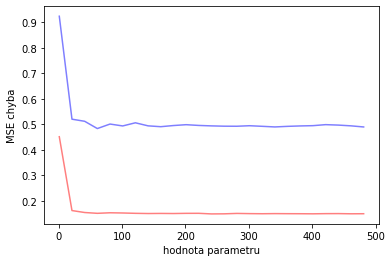

In [207]:
# vykresleni, jak se meni MSE pri pouzitych n estimators
plt.plot(idxs,MSE_train,color='red',alpha=0.5)
plt.plot(idxs,MSE_val,color='blue',alpha=0.5)


plt.xlabel('hodnota parametru')
plt.ylabel('MSE chyba')

R^2: 0.52
R: 0.72
MSE: 0.50
Pearsons correlation: 0.721


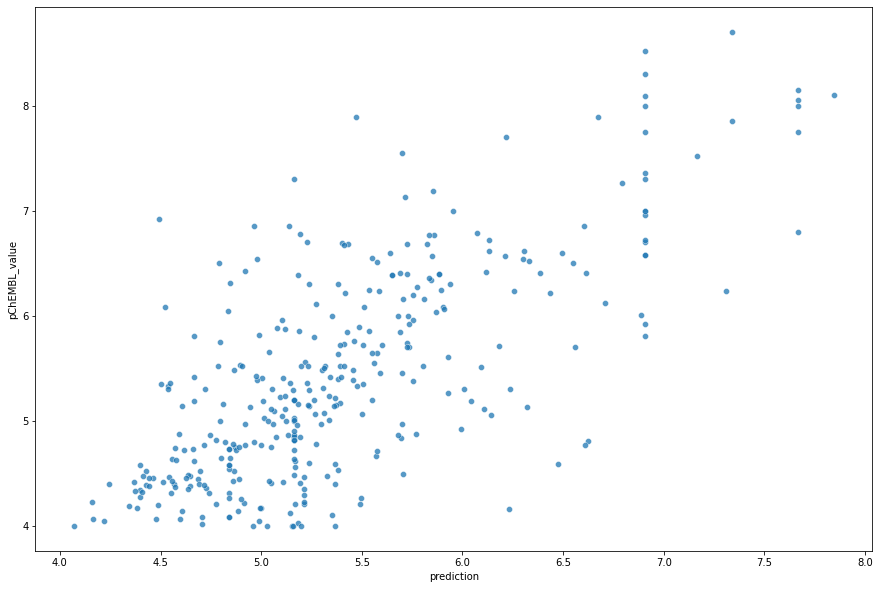

In [211]:
finaly_good_model = ensemble.RandomForestRegressor(n_estimators = 81)
finaly_good_model.fit(X_train, trainset["pChEMBL_value"])
forest_results = get_results_fps_val(finaly_good_model,validationset, X_val, "pChEMBL_value")

print("R^2: %0.2f" % finaly_good_model.score(X_val, validationset["pChEMBL_value"]))
print("R: %0.2f" % np.sqrt(finaly_good_model.score(X_val, validationset["pChEMBL_value"])))
print("MSE: %0.2f" %  mean_squared_error(forest_results["prediction"], forest_results["pChEMBL_value"]))
corr, _ = pearsonr(forest_results["prediction"], forest_results["pChEMBL_value"])
print('Pearsons correlation: %.3f' % corr)

fig, ax = plt.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="prediction",
                      y="pChEMBL_value",
                      data=forest_results,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

podobně jako původní random forest, ideál je někde kolem 100 estimators

### SVR

In [213]:
# postupne jsem vyzkousela vsechny kernely
kernels=['rbf','poly','sigmoid','linear']
for k in kernels:
    svr_p = svm.SVR(kernel=k)
    svr_p.fit(X_train, trainset["pChEMBL_value"])
    res_svr_p_val = get_results_fps_val(svr_p,validationset, X_val, "pChEMBL_value")
    
    print('\n'+str(k))
    print("R^2: %0.2f" % svr_p.score(X_val, validationset["pChEMBL_value"]))
    print("R: %0.2f" % np.sqrt(svr_p.score(X_val, validationset["pChEMBL_value"])))
    print("MSE: %0.2f" %  mean_squared_error(res_svr_p_val["prediction"], res_svr_p_val["pChEMBL_value"]))
    corr, _ = pearsonr(res_svr_p_val["prediction"], res_svr_p_val["pChEMBL_value"])
    print('Pearsons correlation: %.3f' % corr)


rbf
R^2: 0.46
R: 0.68
MSE: 0.56
Pearsons correlation: 0.699

poly
R^2: 0.28
R: 0.53
MSE: 0.74
Pearsons correlation: 0.564

sigmoid
R^2: 0.04
R: 0.20
MSE: 0.99
Pearsons correlation: 0.448

linear
R^2: -0.97
R: nan
MSE: 2.03
Pearsons correlation: 0.396


/home/simik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.



linear
R^2: 0.46
R: 0.68
MSE: 0.56
Pearsons correlation: 0.699


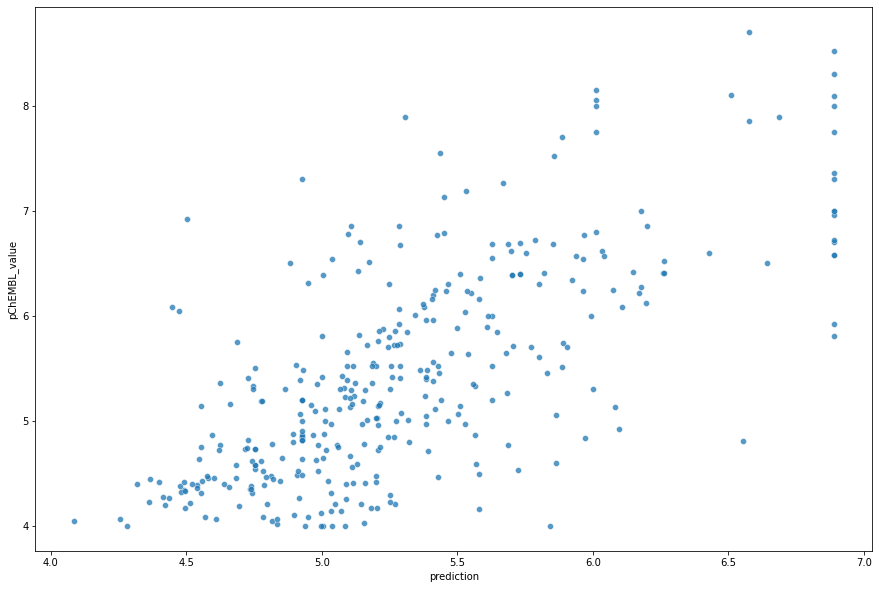

In [214]:
# nejlepe dopadlo rbf jadro, ale stale je to horsi nez randomfores
svr_p = svm.SVR(kernel='rbf')
svr_p.fit(X_train, trainset["pChEMBL_value"])
res_svr_p_val = get_results_fps_val(svr_p,validationset, X_val, "pChEMBL_value")

print("R^2: %0.2f" % svr_p.score(X_val, validationset["pChEMBL_value"]))
print("R: %0.2f" % np.sqrt(svr_p.score(X_val, validationset["pChEMBL_value"])))
print("MSE: %0.2f" %  mean_squared_error(res_svr_p_val["prediction"], res_svr_p_val["pChEMBL_value"]))
corr, _ = pearsonr(res_svr_p_val["prediction"], res_svr_p_val["pChEMBL_value"])
print('Pearsons correlation: %.3f' % corr)

fig, ax = plt.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="prediction",
                      y="pChEMBL_value",
                      data=res_svr_p_val[res_svr_p_val["pChEMBL_value"]>0],
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

random forest je oproti SVR na tom lépe, pro SVR mi vyšlo nejlepší použít rbf jádro

### XGBoost
- tady jsem se snažila projít věechny zásadní parametry

- parametr learning rate

In [103]:
idxs = [i for i in np.arange(0.01,0.11,0.01)]
MSE_train,MSE_val = [], []

for i in idxs:
    
    print(i)
    xgb_model = xgboost.XGBRegressor(learning_rate=i)
    xgb_model.fit(X_train, trainset["pChEMBL_value"])
    
    xgb_train = get_results_fps_val(xgb_model,trainset, X_train, "pChEMBL_value")
    xgb_val = get_results_fps_val(xgb_model,validationset, X_val, "pChEMBL_value")

    
    MSE_train.append(mean_squared_error(xgb_train["prediction"], xgb_train["pChEMBL_value"]))
    MSE_val.append(mean_squared_error(xgb_val["prediction"], xgb_val["pChEMBL_value"]))

0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999


tak je o kapanek horsi nez support vector machine, takze taky nic

Text(0.5, 0, 'MSE chyba')

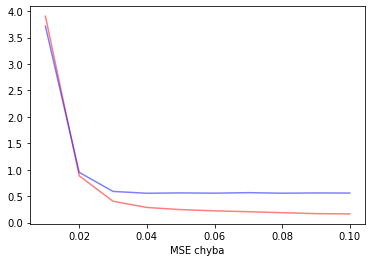

In [99]:
# vykresleni MSE z validacni mnoziny a trenovaci mnoziny
plt.plot(idxs,MSE_train,color='red',alpha=0.5)
plt.plot(idxs,MSE_val,color='blue',alpha=0.5)


plt.xlabel('hodnota parametru')
plt.ylabel('MSE chyba')

- parametr subsample 

In [108]:
idxs = [i for i in np.arange(0.1,0.8,0.1)]
MSE_train,MSE_val = [], []

for i in idxs:
    
    print(i)
    xgb_model = xgboost.XGBRegressor(subsample=i)
    xgb_model.fit(X_train, trainset["pChEMBL_value"])
    
    xgb_train = get_results_fps_val(xgb_model,trainset, X_train, "pChEMBL_value")
    xgb_val = get_results_fps_val(xgb_model,validationset, X_val, "pChEMBL_value")

    
    MSE_train.append(mean_squared_error(xgb_train["prediction"], xgb_train["pChEMBL_value"]))
    MSE_val.append(mean_squared_error(xgb_val["prediction"], xgb_val["pChEMBL_value"]))

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001


Text(0, 0.5, 'MSE chyba')

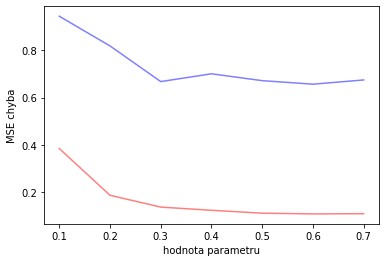

In [111]:
# vykresleni MSE pro validacni mnozinu a trenovaci mnozinu
plt.plot(idxs,MSE_train,color='red',alpha=0.5)
plt.plot(idxs,MSE_val,color='blue',alpha=0.5)


plt.xlabel('hodnota parametru')
plt.ylabel('MSE chyba')

- parametr gamma (snad se jedná penalizaci)

In [112]:
idxs = [i for i in np.arange(0.1,10,0.2)]
MSE_train,MSE_val = [], []

for i in idxs:
    
    xgb_model = xgboost.XGBRegressor(gamma=i)
    xgb_model.fit(X_train, trainset["pChEMBL_value"])
    
    xgb_train = get_results_fps_val(xgb_model,trainset, X_train, "pChEMBL_value")
    xgb_val = get_results_fps_val(xgb_model,validationset, X_val, "pChEMBL_value")

    
    MSE_train.append(mean_squared_error(xgb_train["prediction"], xgb_train["pChEMBL_value"]))
    MSE_val.append(mean_squared_error(xgb_val["prediction"], xgb_val["pChEMBL_value"]))

Text(0, 0.5, 'MSE chyba')

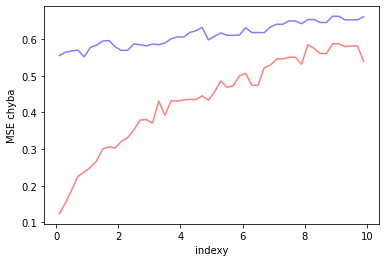

In [113]:
# plot na MSE chybu validacni a trenovaci mnoziny
plt.plot(idxs,MSE_train,color='red',alpha=0.5)
plt.plot(idxs,MSE_val,color='blue',alpha=0.5)


plt.xlabel('hodnota parametru')
plt.ylabel('MSE chyba')

- parametr n_estimators

In [140]:
idxs = [i for i in np.arange(1,600,30)]
MSE_train,MSE_val = [], []
j=50

for i in idxs:
#     print(i)
    if(i>j):
        print(i)
        j+=50
    xgb_model = xgboost.XGBRegressor(n_estimators=i)
    xgb_model.fit(X_train, trainset["pChEMBL_value"])
    
    xgb_train = get_results_fps_val(xgb_model,trainset, X_train, "pChEMBL_value")
    xgb_val = get_results_fps_val(xgb_model,validationset, X_val, "pChEMBL_value")

    
    MSE_train.append(mean_squared_error(xgb_train["prediction"], xgb_train["pChEMBL_value"]))
    MSE_val.append(mean_squared_error(xgb_val["prediction"], xgb_val["pChEMBL_value"]))

61
121
151
211
271
301
361
421
451
511
571


(0.0, 2.0)

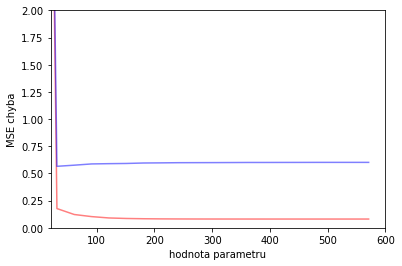

In [149]:
# chyba MSE validacni a trenovaci mnoziny
plt.plot(idxs,MSE_train,color='red',alpha=0.5)
plt.plot(idxs,MSE_val,color='blue',alpha=0.5)


plt.xlabel('hodnota parametru')
plt.ylabel('MSE chyba')
plt.xlim(20,600)
plt.ylim(0,2)

zvolila jsem nakonec nastavení parametrů takto: 
- learning rate na 0.06, 
- subsample = 0.3, 
- gamma=0.3
- n_estimators 170

R^2: 0.50
R: 0.71
MSE: 0.51
Pearsons correlation: 0.711


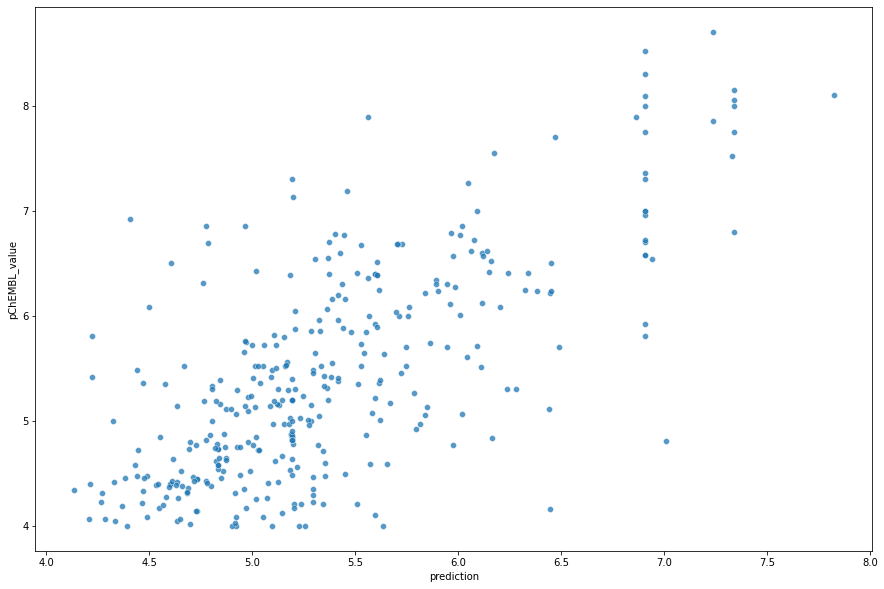

In [221]:
xgb_model = xgboost.XGBRegressor(learning_rate=0.06,subsample = 0.3,n_estimators=170,gamma=0.3)

xgb_model.fit(X_train, trainset["pChEMBL_value"])
xgb_train = get_results_fps_val(xgb_model,trainset, X_train, "pChEMBL_value")
xgb_val = get_results_fps_val(xgb_model,validationset, X_val, "pChEMBL_value")

print("R^2: %0.2f" % xgb_model.score(X_val, validationset["pChEMBL_value"]))
print("R: %0.2f" % np.sqrt(xgb_model.score(X_val, validationset["pChEMBL_value"])))
print("MSE: %0.2f" %  mean_squared_error(xgb_val["prediction"], xgb_val["pChEMBL_value"]))
corr, _ = pearsonr(xgb_val["prediction"], xgb_val["pChEMBL_value"])
print('Pearsons correlation: %.3f' % corr)

fig, ax = plt.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="prediction",
                      y="pChEMBL_value",
                      data=xgb_val,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

vychází to podobně jako random forest nebo SVR, takže bohužel žádné zlepšení

## Podobné látk
- napadlo mě zkusit zúžit moji datovou sadu jen na látky podobné podle vypočtených deskriptorů HBA, HBD, MW, LogP, TPSA, RB
- to predikci modelů zhoršilo, takže tudy cesta nevede

In [222]:
df_temp

,smiles,rdmol,source,pChEMBL_value,standard_value,std_rdmol,std_smiles,fps,HBA,HBD,MW,LogP,TPSA,RB
0,COc1ccc(/C=N/c2ccc(S(N)(=O)=O)cc2)cc1O,<rdkit.Chem.rdchem.Mol object at 0x7f0f482fea30>,cox1,4.36,43800.0,<rdkit.Chem.rdchem.Mol object at 0x7f0f487f3df0>,COc1ccc(/C=N/c2ccc(S(N)(=O)=O)cc2)cc1O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.0,2.0,306.067428,1.79880,101.98,4.0
1,COc1cc(/C=N/c2ccc(S(N)(=O)=O)cc2)ccc1O,<rdkit.Chem.rdchem.Mol object at 0x7f0f482ffc10>,cox1,4.11,78200.0,<rdkit.Chem.rdchem.Mol object at 0x7f0f487e6350>,COc1cc(/C=N/c2ccc(S(N)(=O)=O)cc2)ccc1O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.0,2.0,306.067428,1.79880,101.98,4.0
2,Nc1ccc(C(=O)Nc2ccc(C(F)(F)F)cc2)nc1,<rdkit.Chem.rdchem.Mol object at 0x7f0f482ffc60>,cox1,0.00,100000.0,<rdkit.Chem.rdchem.Mol object at 0x7f0f487df800>,Nc1ccc(C(=O)Nc2ccc(C(F)(F)F)cc2)nc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.0,2.0,281.077597,2.93490,68.01,2.0
3,COc1ccc(-c2noc(CC(=O)O)c2-c2ccc(OC)cc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7f0f487e83a0>,cox1,8.85,1.4,<rdkit.Chem.rdchem.Mol object at 0x7f0f487fe260>,COc1ccc(-c2noc(CC(=O)O)c2-c2ccc(OC)cc2)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.0,1.0,339.110673,3.65290,81.79,6.0
4,CS(=O)(=O)c1ccc(C2=C(c3ccccc3)C(=O)OC2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7f0f487e8800>,cox1,4.94,11400.0,<rdkit.Chem.rdchem.Mol object at 0x7f0f487108a0>,CS(=O)(=O)c1ccc(C2=C(c3ccccc3)C(=O)OC2)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.0,0.0,314.061280,2.55770,60.44,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4109,COc1ccc(-n2nc(C(F)(F)F)cc2-c2ccc(Cl)cc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7f0f487c07b0>,cox1,7.28,53.0,<rdkit.Chem.rdchem.Mol object at 0x7f0f486c4940>,COc1ccc(-n2nc(C(F)(F)F)cc2-c2ccc(Cl)cc2)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.0,0.0,352.059025,5.22010,27.05,3.0
4110,Cc1ccc(-n2nc(COC(=O)COc3cc(O)c4c(=O)cc(-c5cccc...,<rdkit.Chem.rdchem.Mol object at 0x7f0f487c08f0>,cox1,4.30,49640.0,<rdkit.Chem.rdchem.Mol object at 0x7f0f486c4210>,Cc1ccc(-n2nc(COC(=O)COc3cc(O)c4c(=O)cc(-c5cccc...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8.0,1.0,592.140114,7.10232,103.79,8.0
4111,CC(C)(C)C1=NN(c2ccc(C(=O)O)cc2)C(c2ccccc2)C1,<rdkit.Chem.rdchem.Mol object at 0x7f0f487c05d0>,cox1,0.00,100000.0,<rdkit.Chem.rdchem.Mol object at 0x7f0f486c42b0>,CC(C)(C)C1=NN(c2ccc(C(=O)O)cc2)C(c2ccccc2)C1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.0,1.0,322.168128,4.73830,52.90,3.0
4112,CC(C)(C)C1=NN(c2ccc(S(=O)(=O)O)cc2)C(c2ccc(F)c...,<rdkit.Chem.rdchem.Mol object at 0x7f0f487c0b70>,cox1,0.00,100000.0,<rdkit.Chem.rdchem.Mol object at 0x7f0f48682760>,CC(C)(C)C1=NN(c2ccc(S(=O)(=O)O)cc2)C(c2ccc(F)c...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.0,1.0,376.125692,4.42590,69.97,3.0


vykreslila jsem si boxploty a histogramy, abych zjistila, v jakém rozmezí hodnot se pohybuje nejvíce látek 

<AxesSubplot:>

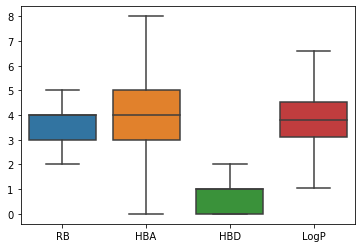

In [276]:
import seaborn as sns
sns.boxplot(data=df_temp[['RB', 'HBA', 'HBD', 'LogP']], showfliers=False)

1
2
3
4


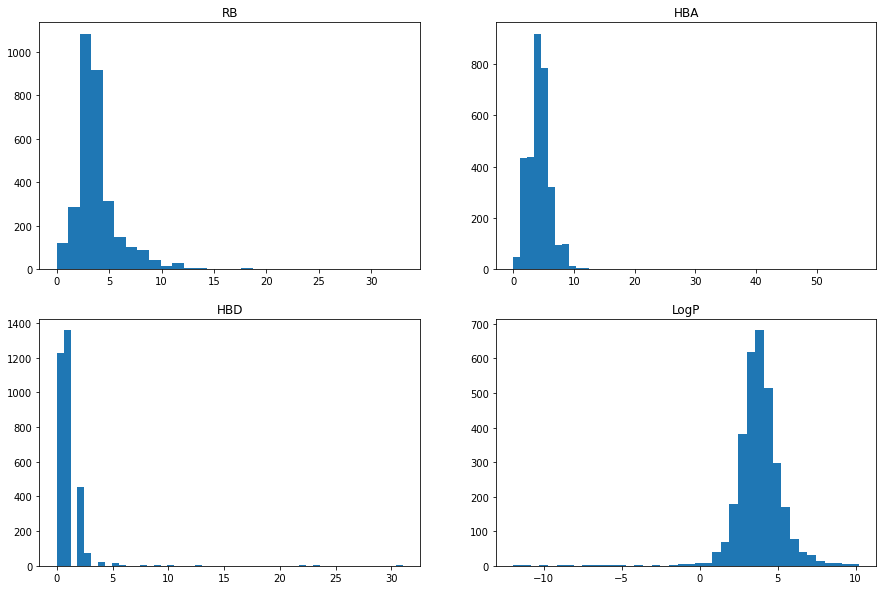

In [277]:
fig = plt.figure(figsize=(15,10))
cols=['RB','HBA','HBD','LogP']
wb=[30,50,50,40]

for c in range(1,len(cols)+1):
    print(c)
    plt.subplot(2, 2, c)
    plt.hist(df_temp[cols[c-1]],bins=wb[c-1])
    plt.title(cols[c-1])
    

<AxesSubplot:>

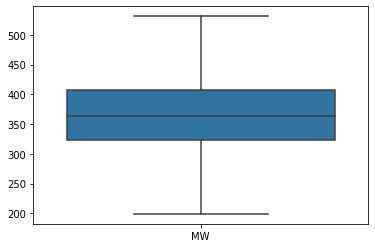

In [280]:
sns.boxplot(data=df_temp[['MW']], showfliers = False)

<AxesSubplot:>

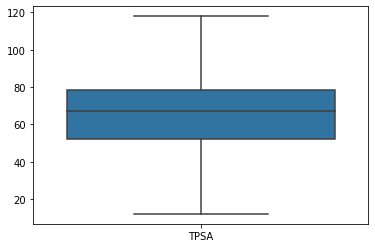

In [281]:
sns.boxplot(data=df_temp[['TPSA']], showfliers = False)

1
2


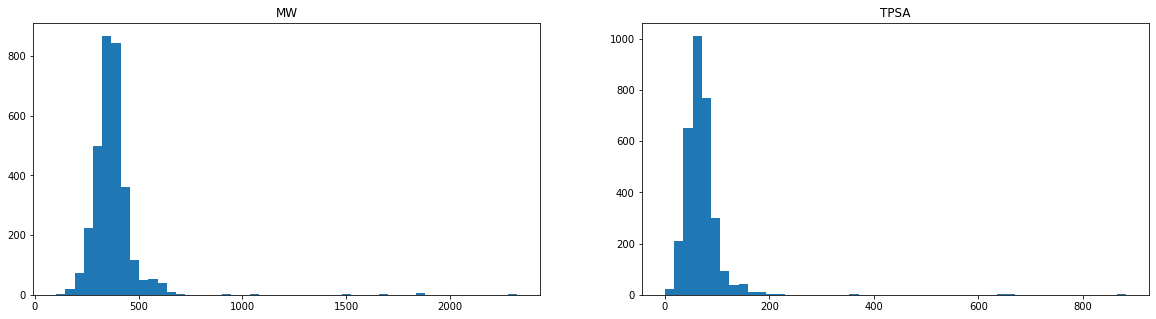

In [279]:
fig = plt.figure(figsize=(20,5))
cols=['MW', 'TPSA']
wb=[50,50]

for c in range(1,len(cols)+1):
    print(c)
    plt.subplot(1, 2, c)
    plt.hist(df_temp[cols[c-1]],bins=wb[c-1])
    plt.title(cols[c-1])
    

- pak jsem si vyselektovala data z původní množiny ligandů podle podminek, které mi nastavily rozsah pro jednotlivé vlastnosti 
- zkusila jsem být přísná přísná a pak i volnější, kdy jsem omezila jen logP a molecular weight, ale výsledek predikce modelů se zhoršil v obou případech

In [364]:
# omezila jsem se na latky sobe podobne, ktere maji podobne skaly vlastnosti a je jich nejvice
df_temp=df_cox
# df_temp = df_temp.loc[(df_temp['RB']>3) & (df_temp['RB']<5)&
#    (df_temp['HBA']>=2)&(df_temp['HBA']<=6) &
#    (df_temp['LogP']>=2)&(df_temp['LogP']<=5)& 
#    (df_temp['HBD']>=0)&(df_temp['HBD']<=3) &
#    (df_temp['MW']>=300)&(df_temp['MW']<=450) & 
#    (df_temp['TPSA']>=40)&(df_temp['TPSA']<=100)
#   ]

df_temp = df_temp.loc[
   (df_temp['LogP']>=2)&(df_temp['LogP']<=4.5)&
   (df_temp['MW']>=320)&(df_temp['MW']<=405)
  ]

df_temp.shape[0]

1244

In [365]:
trainset, testset = ms.train_test_split(df_temp[df_temp["pChEMBL_value"]>0])
trainset.reset_index(inplace=True)
testset.reset_index(inplace=True)

len(trainset), len(testset)

(527, 176)

In [366]:
from sklearn.preprocessing import StandardScaler

st = StandardScaler()
X_train = np.array(list(trainset['fps']))
X_train= st.fit_transform(X_train)

X_test = np.array(list(testset['fps']))
X_test= st.fit_transform(X_test)
# trainset['fps'] = [x for x in X]

### Randomforest

In [367]:
finaly_good_model = ensemble.RandomForestRegressor()
finaly_good_model.fit(X_train, trainset["pChEMBL_value"])

RandomForestRegressor()

In [368]:
train_results = get_results_fps(finaly_good_model, trainset, X_train, "pChEMBL_value")

Average error whole set: 0.3082529503196218


In [369]:
test_results = get_results_fps(finaly_good_model, testset, X_test, "pChEMBL_value")

Average error whole set: 0.5360485353788316


In [370]:
print("R^2: %0.2f" % finaly_good_model.score(X_test, testset["pChEMBL_value"]))
print("R: %0.2f" % np.sqrt(finaly_good_model.score(X_test, testset["pChEMBL_value"])))
print("MSE: %0.2f" %  mean_squared_error(test_results["prediction"], test_results["pChEMBL_value"]))
corr, _ = pearsonr(test_results["prediction"], test_results["pChEMBL_value"])
print('Pearsons correlation: %.3f' % corr)

R^2: 0.52
R: 0.72
MSE: 0.54
Pearsons correlation: 0.727


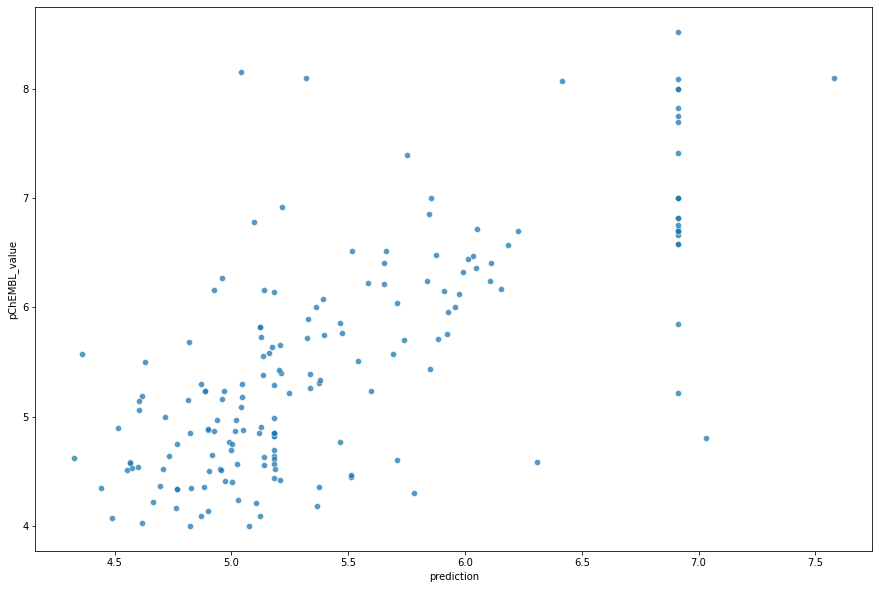

In [371]:
fig, ax = plt.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="prediction",
                      y="pChEMBL_value",
                      data=test_results,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

zůžení množiny nepomohlo

### SVR


linear
R^2: 0.48
R: 0.69
MSE: 0.58
Pearsons correlation: 0.719


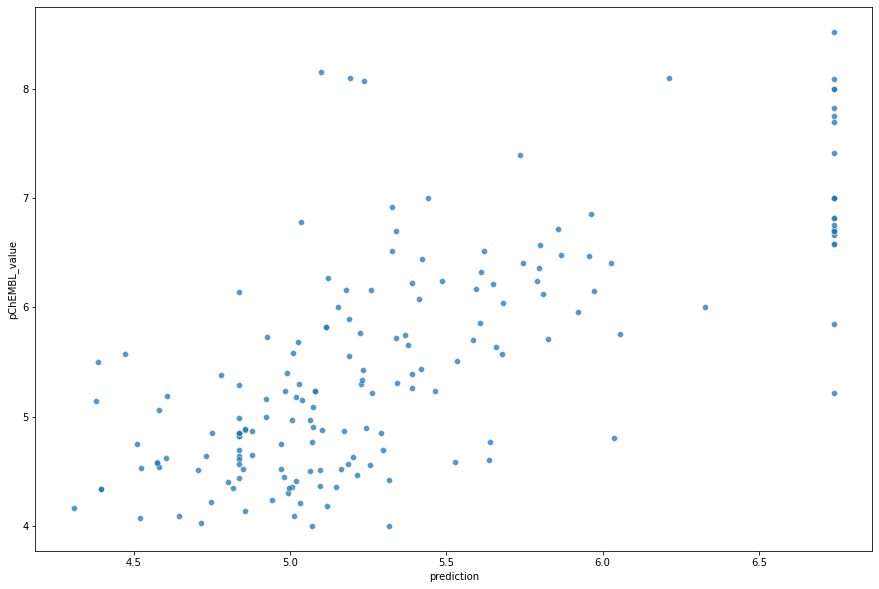

In [372]:
# nejlepe dopadlo rbf jadro, ale stale je to horsi nez randomfores
svr_p = svm.SVR(kernel='rbf')
svr_p.fit(X_train, trainset["pChEMBL_value"])
res_svr_p_val = get_results_fps_val(svr_p,testset, X_test, "pChEMBL_value")

print('\n'+str(k))
print("R^2: %0.2f" % svr_p.score( X_test, testset["pChEMBL_value"]))
print("R: %0.2f" % np.sqrt(svr_p.score( X_test, testset["pChEMBL_value"])))
print("MSE: %0.2f" %  mean_squared_error(res_svr_p_val["prediction"], res_svr_p_val["pChEMBL_value"]))
corr, _ = pearsonr(res_svr_p_val["prediction"], res_svr_p_val["pChEMBL_value"])
print('Pearsons correlation: %.3f' % corr)

fig, ax = plt.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="prediction",
                      y="pChEMBL_value",
                      data=res_svr_p_val[res_svr_p_val["pChEMBL_value"]>0],
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

tady to taky nepomohlo

### XGBoost

R^2: 0.50
R: 0.71
MSE: 0.56
Pearsons correlation: 0.719


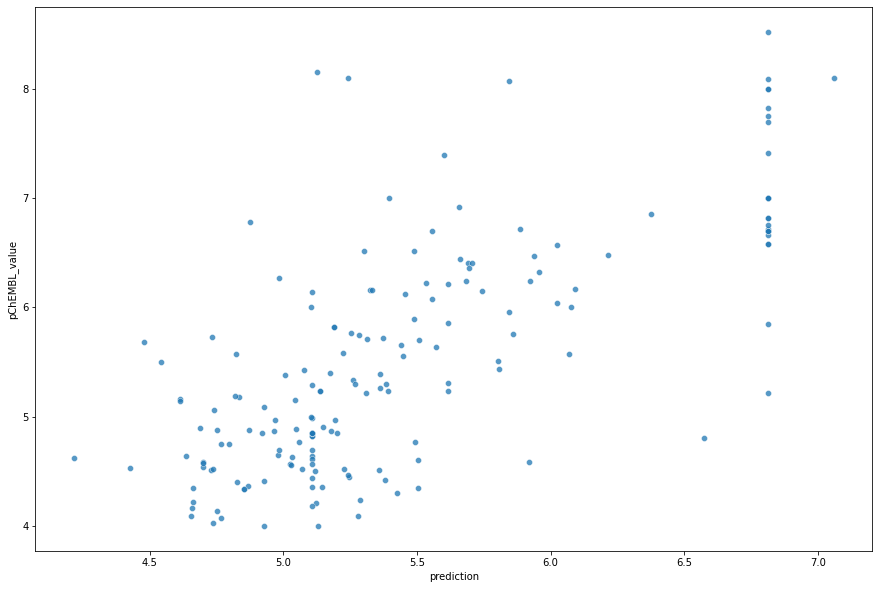

In [374]:
xgb_model = xgboost.XGBRegressor(learning_rate=0.05,subsample = 0.4,n_estimators=100,gamma=0.8)

xgb_model.fit(X_train, trainset["pChEMBL_value"])
xgb_train = get_results_fps_val(xgb_model,trainset, X_train, "pChEMBL_value")
xgb_val = get_results_fps_val(xgb_model,testset, X_test, "pChEMBL_value")

print("R^2: %0.2f" % xgb_model.score(X_test, testset["pChEMBL_value"]))
print("R: %0.2f" % np.sqrt(xgb_model.score(X_test, testset["pChEMBL_value"])))
print("MSE: %0.2f" %  mean_squared_error(xgb_val["prediction"], xgb_val["pChEMBL_value"]))
corr, _ = pearsonr(xgb_val["prediction"], xgb_val["pChEMBL_value"])
print('Pearsons correlation: %.3f' % corr)

fig, ax = plt.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="prediction",
                      y="pChEMBL_value",
                      data=xgb_val,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

tady taky nic

### Znovu ladění hyperparametrů
- z dřívějších modelů mi asi nejlépe vyšel RandomForest, proto jsem se pokusila ještě o jedno ladění hyperparametrů, ale použila jsem random search hyperparametrů, který vyzkoušel několik kombinací a vybral to nejlepší

In [53]:
# zkusim zase z puvodniho setu
df_temp=df_cox

trainset, testset = ms.train_test_split(df_temp[df_temp["pChEMBL_value"]>0])
trainset.reset_index(inplace=True)
testset.reset_index(inplace=True)
# rozdeleni cirka 75:25
len(trainset), len(testset)

from sklearn.preprocessing import StandardScaler

st = StandardScaler()
X_train = np.array(list(trainset['fps']))
X_train= st.fit_transform(X_train)

X_test = np.array(list(testset['fps']))
X_test= st.fit_transform(X_test)
# trainset['fps'] = [x for x in X]

In [54]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [55]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf =  ensemble.RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, trainset["pChEMBL_value"])

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

parametry nejlepšího modelu

In [56]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': False}

In [61]:
test_results = get_results_fps_val(rf_random, testset, X_test, "pChEMBL_value")

print("R^2: %0.2f" % rf_random.score(X_test, testset["pChEMBL_value"]))
print("R: %0.2f" % np.sqrt(rf_random.score(X_test, testset["pChEMBL_value"])))
print("MSE: %0.2f" %  mean_squared_error(test_results["prediction"], test_results["pChEMBL_value"]))
corr, _ = pearsonr(test_results["prediction"], test_results["pChEMBL_value"])
print('Pearsons correlation: %.3f' % corr)

R^2: 0.48
R: 0.69
MSE: 0.48
Pearsons correlation: 0.692


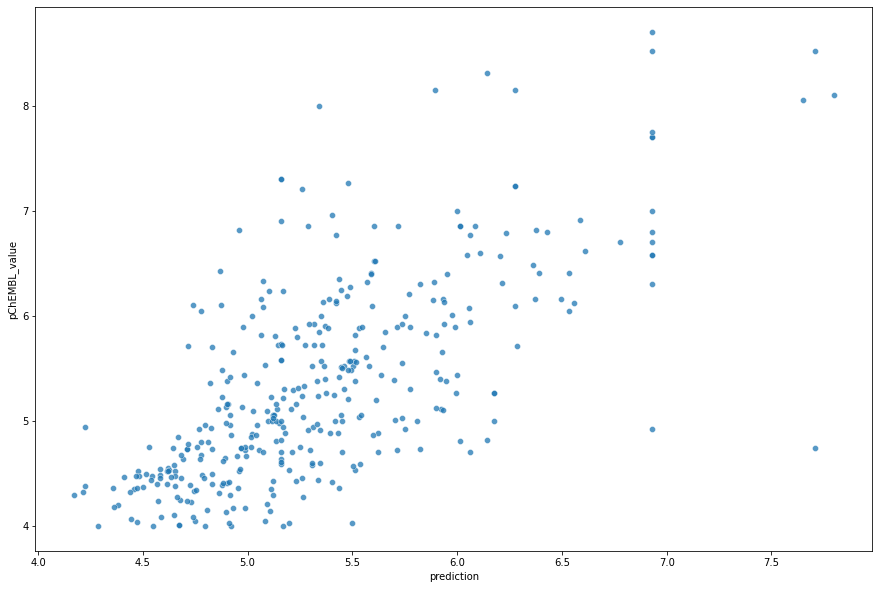

In [62]:
fig, ax = plt.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="prediction",
                      y="pChEMBL_value",
                      data=test_results,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

- tento model je je o něco málo lepší než předešlý randomForest, má asi o 0.02 menší MSE
- nebyla jsem schopná pro svoje data najít nějaký vhodný model a nenapdá mě, co dalšího použít pro zlepšení predikce